<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3681 entries, 0 to 3680
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Topic    3681 non-null   object
 1   Content  3681 non-null   object
dtypes: object(2)
memory usage: 57.6+ KB
               Topic                                            Content
2471   ['pháp luật']  ['cựu', 'bộ trưởng', 'vũ', 'huy hoàng', 'đề ng...
2602   ['pháp luật']  ['thủ đoạn', 'ép', 'nữ', 'tiếp viên', 'bán dâm...
1470  ['kinh doanh']  ['giá', 'xăng dầu', 'đồng loạt', '16', 'h30', ...
2824   ['pháp luật']  ['hai', 'đầu nậu', 'xăng', 'sài gòn', 'long', ...
3599    ['giáo dục']  ['đại học', 'tài nguyên', 'môi trường', 'hà', ...
Found 8772 unique tokens.
Shape of data tensor: (3681, 250)
Shape of label tensor: (3681, 6)
(2944, 250) (2944, 6)
(737, 250) (737, 6)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape         

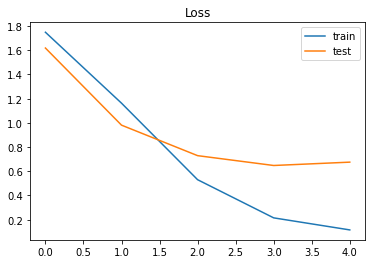

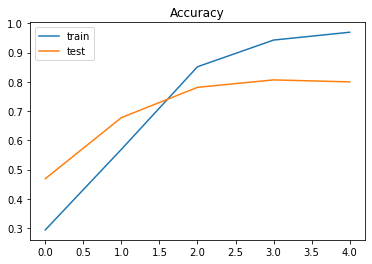

[[0.22925207 0.09052455 0.13489676 0.11956731 0.18341337 0.24234594]] Giải trí


In [2]:
import pandas as pd
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.utils import shuffle
import numpy as np
from tensorflow.python.keras.callbacks import EarlyStopping

df = pd.read_csv('./data/preprocessing.csv')
df.info()

df = shuffle(df)
print(df.head())
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['Content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df['Topic']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

new_complaint = ['Hai chú cháu bị điện giật khi cẩu cây']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Thời sự', 'Thế giới', 'Kinh doanh', 'Pháp luật', 'Giáo dục', 'Giải trí']
print(pred, labels[np.argmax(pred)])